In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import cluster
import itertools
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Word Embeddings and Visualizations Using Gensim

## Embedding with GloVe & Word2Vec

GloVe and Word2Vec are two of the most popular embedding algorithms used in NLP today. Each of these algorithms can be implemented on any set of text data (the bigger the better), and there are two pre-trained and widely used implementations that are easily downloadable. Word2Vec's can be found [here](https://code.google.com/archive/p/word2vec/), and it was trained on a Google News Corpus in 2013. GloVe's can be found [here](https://nlp.stanford.edu/projects/glove/), and it was trained on WikiPedia data in 2014.

All you need to do in order to upload the library of words with their vector representations is download the documents from the links above and parse them as I do below. The libray Gensim makes reading in our embeddings very easy, and it also offers a ton of great features for comparing words. In this analysis we read in the embeddings as words represented as vectors of length 300, but there are other options available.

In [2]:
glove_file = datapath('/Users/JRacanelli/Downloads/glove.6B/glove.6B.300d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")
glove2word2vec(glove_file, tmp_file)
# a dictionary like object containing our words represented as GloVe computed vectors
glove = KeyedVectors.load_word2vec_format(tmp_file)
# a dictionary like object containing our words represented as Word2Vec computed vectors
w2v = gensim.models.KeyedVectors.load_word2vec_format('/Users/JRacanelli/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

## Visualizing our Word Embeddings

Humans understand language as a multitude of associations, and we can think of words as being related to one another. When you read a word like 'enormous' you might begin to think of other words like 'big', or 'gigantic' to help with your understanding. Our brains have established relationships between words, and we can begin to think of words like 'big' and 'enormous' living very "close" to eachother within our language. We can further establish relationships such as "small" being the opposite of big, and having both words in a category of descriptive 'size' words. 

Word2Vec and GloVe are able to infer similar things from large enough amounts of data. Instead of understanding words as we do, our algorithms aim to represent words as vectors, which can be understood as points in a vector space - let's call it our language space. We can now begin to understand where words live in relation to one another. So, continuing our example above, we might be able to find 'big', 'enormous', and 'gigantic' living very close to eachother in our language space. We might further be able to define relationships like 'big' is the opposite of 'small', and both of these words live close to other descriptive size words.

This makes sense in a handwavey sort of way, but we can actually demonstrate this graphically. Our words are now described as vectors of length 300, but we can perform principal component analysis on these vectors and reduce the dimensionality to something we can actually plot. Most of the relationships between our words will, hopefully, be preserved by our PCA. Besides just plotting the points, we can also perform a simple cluster analysis to see how these words are grouped by different clustering algorithms. 

I create a function that takes a set of word embeddings, a list of words, a clustering algorithm, and a specified number of clusters and plots our words (after undergoing PCA) in 2-dimensions. The points are labeled with the words associated, and colored by the clusters that they ended up in. 

In [3]:
def plot_words(embeddings, words, cluster, n_clusters, title = False):
    arrays = []
    for word in words:
        arrays.append(embeddings[word])
        
    pca = PCA(n_components = 2)
    pca.fit(arrays)
    pca_words = pca.fit_transform(arrays)
    
    cluster.n_clusters = n_clusters
    cluster = cluster.fit(pca_words)
    labels = cluster.predict(pca_words)
    
    x,y = pca_words.T
    plt.scatter(x,y, c = labels)
    
    for i, word in enumerate(words):
        plt.annotate(word, xy=(x[i], y[i]), xytext=(-3,8), 
            textcoords='offset points')
    if title:
        plt.title(title)
    else:
        plt.title('Words Plotted and Categorized by ' + str(n_clusters) + ' Clusters')

    plt.show()
    plt.close()
    return 

To demonstrate how powerful word embeddings can be I plot a few sets of related words that can easily be grouped by the average person. I leave it an unsupervised exercise and employ K-means clustering to group the words into clusters - setting the `n_clusters` hyperparameter to the number of subgroups I have in my set of words.

The first set of words is `'small','tiny','big','huge','large','gigantic','little','modest'`. It's a set of adjectives that describe size, and there are synonyms of small and synonyms of big. The clustering algorithm is able to correctly separate the words into their synonym subgroups! 

That's not that cool though, it makes sense that a computer can group synonyms. Let's try a less straightforward example. We can use words associated with different systems of government, `'tyrant','dictator','autocrat','republic','communism','socialism','democracy'` are all words that we can associate with different types of government, and someone with a highschool education could probably put these into three groups if they had to. Our embeddings, paired with our clustering algorithm is able to as well! 

There are some interesting things to note about the distances created by these clusters. One might agree that the hardest word in the set to cluster is `'socialism'`. It is certainly not like any of the dictatorship-like words, but where does socialism fall between communism and democracy? It certainly has elements from both, and we are always hearing policies put forth by Democrats called socialist, and some Americans don't even know the difference between communism and socialism. 

The trouble in categorizing `'socialism'` is also visible in our visualization. Note that socialism lives somewhere in between `'communism'`, and `'democracy'` - the cluster is not immediately obvious. We must also remember that our embeddings did not "think" about this clustering problem in the same way we did. The embedding algorithm, instead, picked up on the statistical properties of the language that we fed it, which resulted in geometries that we were able to interpret.  

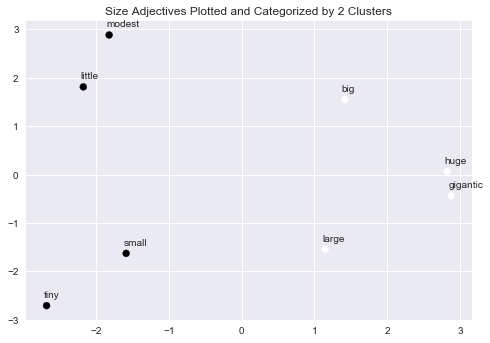

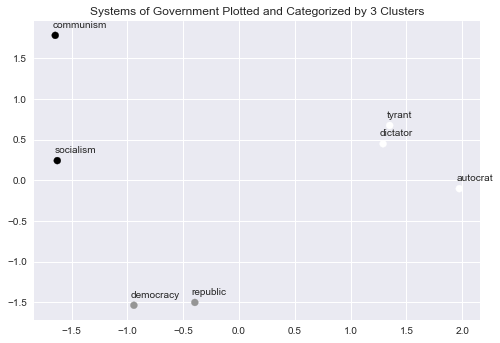

In [4]:
plot_words(glove,['small','tiny','big','huge','large','gigantic','little','modest'],KMeans(),2,
          title='Size Adjectives Plotted and Categorized by 2 Clusters')
plot_words(w2v,['tyrant','dictator','autocrat','republic','communism','socialism','democracy'],KMeans(),3,
          title='Systems of Government Plotted and Categorized by 3 Clusters')

## The Importance of your Input Data

These embeddings are learned from the data that we feed our algorithms. The datasets from Google and Stanford are very different, with Word2Vec's data coming from Google News archives, and GloVe's coming from Wikipedia. The input data completely determines the space of word embeddings, which is why having large and relevant datasets is so important to NLP. Different data sources can come up with wildly different word associations, and we will demonstrate this below.

At the time that these embeddings were computed Donald Trump was not yet president, and had not even mentioned the idea of running. If we check each dataset to see how similar the word `trump` is to the word `president` we will find that they live very far from eachother within our vector space. 

In [5]:
glove.similarity('trump','president')

0.084507439233176246

In [6]:
w2v.similarity('trump','president')

0.029265332098415857

So neither of our datasets were able to make the association between the words `trump` and `president`. That's pretty reasonable; I don't think any of us were able to make that association 5 years ago - perhaps not even the man himself. But what words were associated with the word `trump` in our datasets?

It seems like each dataset had a very different understanding of the word `trump`. GloVe data hones in on Trump the person. This is illustrated by the words associated with him, such as the names of people in his family, as well as words associated with resorts and casinos. Word2Vec, on the other hand, came to associate the word trump with synonyms and derivates of the english word "trump", such as "outweigh" and "trumping". 

While both algorithms produce very different word associations, one can still see how either query returns sensible and interpretable results. The data we feed our algorithms completely determine the mappings that are generated. So, if we were to feed our algorithms more recent news data; our queries would likely yield very different results. We would probably have words like `president`, `election`, and `scandal` living much closer to the word `trump` than they do in either of the examples presented. 

In [7]:
glove.most_similar('trump')

[('ivana', 0.4999052882194519),
 ('melania', 0.45651504397392273),
 ('casino', 0.45222750306129456),
 ('nows', 0.44631344079971313),
 ('knauss', 0.4360748529434204),
 ('hilton', 0.4234514832496643),
 ('trumps', 0.41433754563331604),
 ('ivanka', 0.40609341859817505),
 ('resorts', 0.3992827236652374),
 ('wynn', 0.3902421295642853)]

In [8]:
w2v.most_similar('trump')

[('trumps', 0.7198435068130493),
 ('trumping', 0.580585241317749),
 ('supersede', 0.5600422620773315),
 ('trumped', 0.5497317910194397),
 ('supercede', 0.5309919118881226),
 ('prevail', 0.48776334524154663),
 ('outweigh', 0.4785327613353729),
 ('trample', 0.471425324678421),
 ('overshadow', 0.4701153635978699),
 ('dictate', 0.46754559874534607)]

## Conclusion

Word embeddings are useful for representing words as numbers in a way that defines relationships between words. This allows us to create meaningful inputs for any model we construct to analyze language. When we want to train, for example, something that assesses the tone of a body of text we need a way to feed it the text - a neural network isn't going to understand 'the cat in the hat', but it can understand a a vector of floats which represent those words. 

In the **best case** we can train our embeddings _specifically for_ our task - essentially updating the parameters of our embedding mappings _as well as_ updating the parameters for our neural network at each training step. With enough data, we can arrive at an embedding space that is optimized for our specific task. 

It is often the case that we do not have enough text data to be able to arrive at a particularly meaningful set of word embeddings. In such cases we can use a pretrained set of embeddings (like the ones we've used today), or we can use one of these algorithms on a different set of text to arrive at a different set of embeddings. As an example, if we wanted to have a space of embeddings that made word associations that are relevant today (like the words 'trump', and 'president'), we could input a bunch of news articles from the last year, instead of from when Word2Vec was first trained.
